# Predictor Explainer

The following Python code runs after the user has selected all the `X`'s, `y`, `Datetime` (optional), `Weights` (optional) and other parameters. [PyJMP](https://github.com/industrial-data/pyJMP) needs to be installed.

The main idea is to find variables (`X`'s or tags) that correlate with at certain target (`y`). Intentionally, the purpose is to generate **descriptive models** to find interesting variables to visualize.

More information can be found here:

* [Predictor Explainer](https://github.com/industrial-data/predictor-explainer/pyJMP)
* [Industrial data science – a review of machine learning applications for chemical and process industries](https://pubs.rsc.org/en/content/articlelanding/2022/re/d1re00541c)


In [1]:
__author__ = 'Francisco Navarro; Juline Gillard'
__license__ = "BSD Clause-3"
__version__ = '2022.12.11'
__maintainer__ = 'Francisco Navarro; Carlos Perez-Galvan'
__status__ = 'beta'
__url__ = 'https://github.com/industrial-data/predictor-explainer'

# Loading Python libraries

In [2]:
import numpy as np
import pandas as pd
import shap
import umap
import hdbscan
from lightgbm.sklearn import LGBMRegressor
import matplotlib.pyplot as plt
import time
import os
import re

# To deactivate plots, change to False
is_plotting = True

if is_plotting:
    import umap.plot

# Loading data from temp files (saved by JMP)

<div class="alert alert-block alert-warning">New CSV files are generated only when the user clicks OK in the Predictor Explainer add-in.</div>

In [3]:
temp_data_path = os.path.join(os.path.join(os.environ['USERPROFILE']),
                             'AppData',
                             'Local',
                             'Temp')
print(temp_data_path)

C:\Users\fxn0478\AppData\Local\Temp


In [4]:
y_path_csv = os.path.join(temp_data_path,'y.csv')
X_path_csv = os.path.join(temp_data_path,'X.csv')
t_path_csv = os.path.join(temp_data_path,'t.csv')
W_path_csv = os.path.join(temp_data_path,'W.csv')
user_parameters_csv = os.path.join(temp_data_path,'user_parameters.csv')

is_unspervised_learning = False

try:
    y = pd.read_csv(y_path_csv)
except:
    print("target column couldn't be loaded correctly, assuming unspervised learning ")
    is_unspervised_learning = True

try:
    X = pd.read_csv(X_path_csv)
    JMP_row_index = X['row_index'].copy();
    del X['row_index']
    
except Exception:
    print("X columns couldn't be loaded correctly, make sure they exist")    

try:
    t = pd.read_csv(t_path_csv)
except:
    print('Time column was not defined by user')
    
try:
    W = pd.read_csv(W_path_csv)
except:
    print('Weights were not defined by user')

try:
    JMP_user_parameters = pd.read_csv(user_parameters_csv)
except:
    print('User parameters not defined')

target column couldn't be loaded correctly, assuming unspervised learning 
Time column was not defined by user
Weights were not defined by user


In [5]:
print('Options defined in JMP addin: \n\n', JMP_user_parameters);

Options defined in JMP addin: 

    nTrees  SignalToNoiseRatio  NdimUMAP     metric  nrows
0     100                   1         2  euclidean      1


In [6]:
# This function will be used at the end to create umap from RF selected features
def umap_princ_components(X, n_umap_components=2, distance='euclidean'):
    '''Takes not scaled X(obs,variables) and reduces to n_comp dimensions
    by using umap reducer embedding.
    
    It returns a dataframe with the following columns:
        n_comp (embeddings)
        euclidan distance between consecutive rows
        sum(n_comp)
        labels for clusters
        outlier score based on density'''
    
    #n_umap_components = 2 # default and paper
    
    print('N of umap dimensions', n_umap_components)
    print('Distance metric:', distance)
    
    # Data prep
    
    # Umap does not handle NaNs (TODO improve)
    # Simplest time series approach:
    # forward filled and then back filled
    # (!) Not compatible with batch data
    X_unsupervised = X.copy()
    
    X_unsupervised = X_unsupervised.fillna(method='ffill')
    X_unsupervised = X_unsupervised.fillna(method='bfill')
    
    # Drops any reamining column with of empty values
    X_unsupervised = X_unsupervised.dropna(axis=1, how='all')
    
    # Robust normalization
    X_unsupervised_normalized = ((X_unsupervised-X_unsupervised.quantile(0.03)) /
                                 (X_unsupervised.quantile(0.97)-X_unsupervised.quantile(0.03)))
    
    # If values are fairly constant, (q97-q03) division returns NaN (TODO improve)
    X_unsupervised_normalized = X_unsupervised_normalized.dropna(axis=1, how='any')

    X_unsupervised_normalized = X_unsupervised_normalized.clip(0, 1)
    
    # Dimensionality reduction
    
    # Choice of parameters is indicated but also shared with
    # paper https://doi.org/10.1016/j.conengprac.2019.104189
    
    # TODO Exploit AlignedUMAP for time varying data
    # https://umap-learn.readthedocs.io/en/latest/aligned_umap_politics_demo.html
    
    if distance == 'euclidean':
        y_distance = 'l2'
    
    if distance == 'manhattan':
        y_distance = 'l1'
        
    if is_unspervised_learning:
    
        embedding = umap.UMAP(n_neighbors=15, # default and paper
                            min_dist=0.1, # default and paper
                            n_components=n_umap_components,
                            metric=distance,
                            output_metric=distance,
                            target_metric=y_distance,
                            #random_state=42, # uncomment to get slower but reproducible results
                            ).fit(X_unsupervised_normalized)
    else:
        embedding = umap.UMAP(n_neighbors=15, # default and paper
                            min_dist=0.1, # default and paper
                            n_components=n_umap_components,
                            metric=distance,
                            output_metric=distance,
                            target_metric=y_distance,
                            #random_state=42, # uncomment to get slower but reproducible results
                            ).fit(X_unsupervised_normalized, y=y) #add 'y' as function input
        
        
        
    # Generating umap column names
    umap_col_names = ['umap'+str(i+1) for i in range(n_umap_components)]
    
    # Saving table
    array_umap_components = embedding.embedding_
    df_umap = pd.DataFrame(array_umap_components, columns=umap_col_names)
    

    
    # Clustering and density analysis 

    n_observations = len(X_unsupervised_normalized.index)
    percentual_threshold = 0.05 # % of data required to form cluster 

    # array_umap_components = df_umap.iloc[:,:n_umap_components].values

    clusterer = hdbscan.HDBSCAN(
                        min_samples=5,
                        min_cluster_size=round(percentual_threshold*n_observations),
                        ).fit(array_umap_components)

    labels = clusterer.labels_  

    are_clustered = (labels >= 0) #-1 are unclustered points
    
    df_umap['umap_clusters'] = labels
    df_umap['outlier_score'] = clusterer.outlier_scores_
    
    # Row or time difference
    diff_period = int(JMP_user_parameters['nrows'])
    print('N of rows for finite differences', diff_period)
    
    df_umap_shift = df_umap.shift(periods = diff_period, axis = 0).copy()
    
    if distance == 'euclidean':
        # 2-norm distance between consecutive points
        df_umap['distance_diff_umap'] = np.linalg.norm(df_umap.values - df_umap_shift.values, axis=1)
    
    if distance == 'manhattan':
        # 1-norm distance between consecutive points
        df_umap['distance_diff_umap'] = np.linalg.norm(df_umap.values - df_umap_shift.values, ord=1, axis=1)
    
    
    # IMPORTANT TODO we are adding all umap components as target function
    # this assumes that dimensions have no importance (?) (unlike PCA)
    df_umap['sum_umap_comp'] = df_umap.iloc[:,:n_umap_components].sum(axis=1)
    
    if not(is_unspervised_learning):
        df_umap['y'] = y
        
    df_umap_path_csv = os.path.join(temp_data_path,'df_umap.csv')
    
    df_umap.index = JMP_row_index
    df_umap.to_csv(df_umap_path_csv)
    df_umap = df_umap.reset_index()

    if is_plotting:
        
        if n_umap_components == 1:
            cmap = plt.cm.Paired
            df_umap.reset_index().plot.scatter(x='index', y='umap1', c=cmap(labels), xlabel='row index', ylabel='umap 1D')
        
        if n_umap_components == 2:
            umap.plot.connectivity(embedding, show_points=True, labels=labels)
        #df_umap.plot()
        
        if n_umap_components >= 3:
            
            #cmap = plt.cm.Paired
            
            df_umap_parallel = df_umap[umap_col_names+['umap_clusters']]
            df_umap_parallel = df_umap_parallel[are_clustered]
            
            n_clusters = len(df_umap_parallel['umap_clusters'].unique())
            
            pd.plotting.parallel_coordinates(df_umap_parallel,
                                             'umap_clusters')
    
    return df_umap, n_umap_components



# Unsupervised step (only if target was not given by user)

Reducing dimensionality and using such as target
N of umap dimensions 2
Distance metric: euclidean


The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


N of rows for finite differences 1


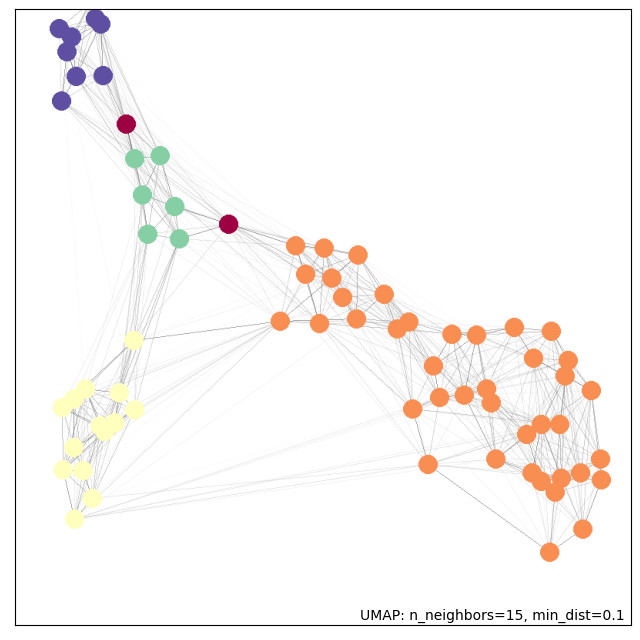

In [7]:
if is_unspervised_learning:
    print('Reducing dimensionality and using such as target')
    
    n_umap_components = int(JMP_user_parameters['NdimUMAP'])
    distance = str(JMP_user_parameters['metric'][0])
    
    df_umap, n_umap_components = umap_princ_components(X, n_umap_components, distance)
    y = df_umap['sum_umap_comp'].copy().to_frame()

# Data preparation

In [8]:
# JMP loads everything as data frames

def rename_df_columns(my_dataframe):
    '''Light GBM does not support special JSON Characters in column names yet
    This function susbtitues by _ all characters in column names that are not letters or numbers'''
    
    print(type(my_dataframe))
    
    # If errors, uncomment the following line.
    my_dataframe = my_dataframe.rename(columns = lambda str_column:re.sub(r'[^A-Za-z0-9_]+','_', str_column))
        
    # Once fixed, the following reg. exp. will keep special JSON charaters
    # my_data_frame = my_data_frame.rename(columns = lambda str_column:re.sub(r'[^\x00-\x7F]+','', str_column))
    
    return my_dataframe


y = rename_df_columns(y) # removing special characters
y = y.iloc[:, 0] # converting df to series


tic = time.time()

# Removes X columns that are non numeric (e.g. dates in X)
X = X.select_dtypes(include=np.number)


# Adding index in case a counter fits the data well (acumulation)
# X['SHAP_row_index'] = range(1, len(X) + 1)
X = rename_df_columns(X) # removing special characters

if y.name in X.columns:
    print('Output columns was given as input! Removing it from X')
    del X[y.name]
    
try:
    t;
except NameError:
    t_exists = False
else:
    t_exists = True
    t = rename_df_columns(t) # removing special characters
    
    #t.to_csv('C:\Temp\JMP_time.csv')
    
    t.iloc[:,0] = pd.to_datetime(t.iloc[:,0], unit='s', origin=pd.Timestamp('1904-01-01'))
    t = t.iloc[:, 0] # converting to series
    
try:
    W;
except NameError:
    W_exists = False
else:
    W_exists = True
    W = rename_df_columns(W) # removing special characters
    
    #W.to_csv('C:\Temp\JMP_weight.csv')
    
    W = W.iloc[:, 0] # converting to series


    
# print('X head: \n', X.head())
# print('X tail: \n', X.tail())
# print('y: \n', y)

assert (len(X) == len(y) ), 'Number of rows of X, y does not match!'

#check if NaN exist in Y, W, t and remove corresponding X 
y.dropna(inplace=True)
index_not_nan = y.index
X = X.loc[index_not_nan,:]

try:
    X = X.drop('N_Rows', axis=1)
except:
    print("N_Rows column was not in X")

JMP_row_index = JMP_row_index[index_not_nan]

if t_exists:
    t = t[index_not_nan]
    t.dropna(inplace=True)
    t_index_not_nan = t.index
    
    y = y[t_index_not_nan]
    X = X.loc[t_index_not_nan,:]
    assert (len(X) == len(y) == len(t)), 'Number of rows of X, y and t does not match'

if W_exists:
    W = W[index_not_nan] 
    W.fillna(0)
    W = (W-W.min())/(W.max()-W.min())
    assert (len(X) == len(y) == len(W)), 'Number of rows of X, y and W does not match'
    weights = W
    
# print('X head (after dropping NaN): \n', X.head())
# print('X tail (after dropping NaN): \n', X.tail())
# print('y (after dropping NaN): \n', y)    

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [9]:
y.to_frame().head(10) # head (after dropping NaNs)

,sum_umap_comp
0,8.162816
1,8.456388
2,10.046206
3,11.111189
4,11.929404
5,11.734850
6,12.375481
7,12.899051
8,16.325907
9,15.075985


In [10]:
X.head(10) # X head (after dropping rows from y NaNs)

,Max_of_Tank_level_Heat,Mean_of_Tank_level_Cooldown,Min_of_Tank_level_Cooldown,Max_of_Tank_level_Cooldown,Sum_of_Tank_level_Heat,Mean_of_Tank_level_Heat,Sum_of_Differential_pressure_mmHg_Deagglomerate,Sum_of_Torque_Nm_Deagglomerate,Sum_of_Random_Uniform_Heat
0,55.545,58.097756,55.491,58.253,2442.730,55.516591,171.057,1935.154,23.411530
1,65.559,65.559000,65.559,65.559,1366.907,65.090810,138.593,2872.215,10.167467
2,74.991,74.991000,74.991,74.991,1643.190,74.690455,84.192,2565.176,10.496692
3,84.425,84.490000,84.490,84.490,1770.017,84.286524,34.241,3412.354,10.545072
4,87.539,87.398000,87.398,87.398,2779.850,84.237879,-165.300,3900.933,18.573039
5,84.393,84.393000,84.393,84.393,1848.322,84.014636,-107.300,2822.730,12.538719
6,76.631,76.675000,76.675,76.675,1903.273,76.130920,-85.860,2462.033,13.998213
7,66.249,66.242000,66.242,66.242,2041.691,63.802844,-67.728,1885.442,16.352761
8,47.008,49.487912,46.597,49.970,1387.369,46.245633,-43.500,997.634,15.025320
9,34.033,36.489600,35.769,36.886,1372.695,33.480366,-39.150,641.186,22.468019


In [11]:
print(X.columns)

Index(['Max_of_Tank_level_Heat', 'Mean_of_Tank_level_Cooldown',
       'Min_of_Tank_level_Cooldown', 'Max_of_Tank_level_Cooldown',
       'Sum_of_Tank_level_Heat', 'Mean_of_Tank_level_Heat',
       'Sum_of_Differential_pressure_mmHg_Deagglomerate',
       'Sum_of_Torque_Nm_Deagglomerate', 'Sum_of_Random_Uniform_Heat'],
      dtype='object')


# Feature generation

In [12]:
diff_period = int(JMP_user_parameters['nrows'])

print('N of rows for finite difference feature', diff_period)

X_diff = X.diff(periods = diff_period, axis = 0).copy()
X_diff.columns = ['Diff_'+col for col in X_diff.columns]

print('Finding and dropping duplicated columns generated automatically')
dup_columns = set(X.columns) & set(X_diff.columns)
X_diff.drop(list(dup_columns), axis=1, inplace=True)

X = pd.concat([X, X_diff], axis=1)

toc = time.time() - tic
print('Loading data time [s]:', round(toc, 2))
tic = time.time()

N of rows for finite difference feature 1
Finding and dropping duplicated columns generated automatically
Loading data time [s]: 0.13


In [13]:
#add some time features

print('Starting date feature generation')

if t_exists and (t.name in X.columns): 
    # User needs to introduce date as X and t 
    print(t.head())
    
    # Check first five years in time column
    # if index was used as time year will be around 1904 (starting date in JMP)
    
    is_date_correct = (1960 <= np.nanmean(t.dt.year[0:5]))
                       
    if is_date_correct:
        print('Creating time features')
    
        #t = t[diff_period:len(t)] # TODO WHY?
    
        day_of_month = True
        day_of_week = True
        day_of_year = True
        week = True
        week_of_month = True
        month = True
        quarter = True
        semester = True
        year = True
        hour = True
        minute = True

        if day_of_month:
            X['day_of_month'] = t.dt.day
        if day_of_week:
            X['day_of_week'] = t.dt.dayofweek
        if day_of_year:
            X['day_of_year'] = t.dt.dayofyear
        if week:
            X['week_of_year'] = t.dt.isocalendar().week
        if week_of_month:
            X['week_of_month'] = t.dt.day.divide(7).apply(np.floor)
        if month:
            X['month'] = t.dt.month
        if quarter:
            X['quarter'] = t.dt.quarter
        if semester:
            X['semester'] = t.dt.month.divide(6).apply(np.ceil) # NEW
        if year:
            X['year'] = t.dt.year
        if hour:
            X['hour'] = t.dt.hour
        if minute:
            X['minute'] = t.dt.minute

toc = time.time() - tic
print('Date parsing finished, total time [s]:', round(toc, 2))
tic = time.time()

Starting date feature generation
Date parsing finished, total time [s]: 0.04


# Modeling (RF LightGBM)

In [14]:
n_trees = int(JMP_user_parameters['nTrees']) # number of trees in the forest

signal_to_noise = float(JMP_user_parameters['SignalToNoiseRatio']) # ratio to remove non features near the noise

#add noise
normalNoise = np.random.normal(size = len(X))
uniNoise = np.random.uniform(size = len(X))

#yy = y.values().copy()
yy = y.to_numpy().copy()
np.random.shuffle(yy)

X['Normal Noise'] = normalNoise
X['Uniform Noise'] = uniNoise
X['Shuffle Yield Noise'] = yy

lgbm = LGBMRegressor(n_estimators = n_trees) #keeping default for the other parameters
if W_exists:
    #weights = np.array(weights).reshape(1,-1).flatten()
    #weights = weights[index_not_nan]  #not needed since lgbm handles missing values
    y_model = lgbm.fit(X,y,sample_weight = np.array(weights).flatten())
else:
    y_model = lgbm.fit(X,y)  #LightGBM (as XGBoost) do not support some character in strings, this is why put X into an array

imp_lgbm = lgbm.feature_importances_
sorted_indices_lgbm = np.argsort(imp_lgbm)[::-1]


toc = time.time() - tic
print('Modeling time [s]:', round(toc, 1))
tic = time.time()


# TODO can we drop columns now so the Tree explainer goes faster?
# If not, we need to rerun this for the explainer

Modeling time [s]: 0.1


# Model (over)fit

<div class="alert alert-block alert-info">
    <b>This is a DESCRIPTIVE model intended to find correlations and anomalies in the data to be analyzed.</b> 
    This means overfitting is expected and the model cannot be used to predict a different data set (as the process may have changed). <b>To expand the scope of this, there should be a proper train/test split in the cell above</b>.
    Alternatively, user can train/test by setting several rows with 0 weights to see if performs equaly well.
</div>

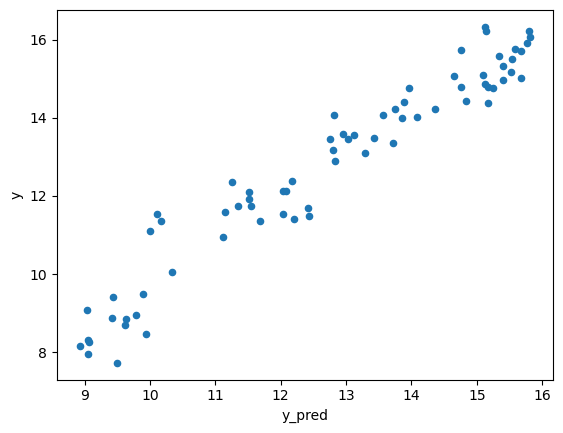

In [15]:
if W_exists:
    y_predictions = y_model.predict(X)
    df_Ys = pd.DataFrame({'y': y, 'y_pred': y_predictions, 'Weight': W})
    df_Ys.plot.scatter(x='y_pred', y='y', c='Weight', colormap='viridis')

else:
    y_predictions = y_model.predict(X)
    df_Ys = pd.DataFrame({'y': y, 'y_pred': y_predictions})
    df_Ys.plot.scatter(x='y_pred', y='y')

# Explainer (shap)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


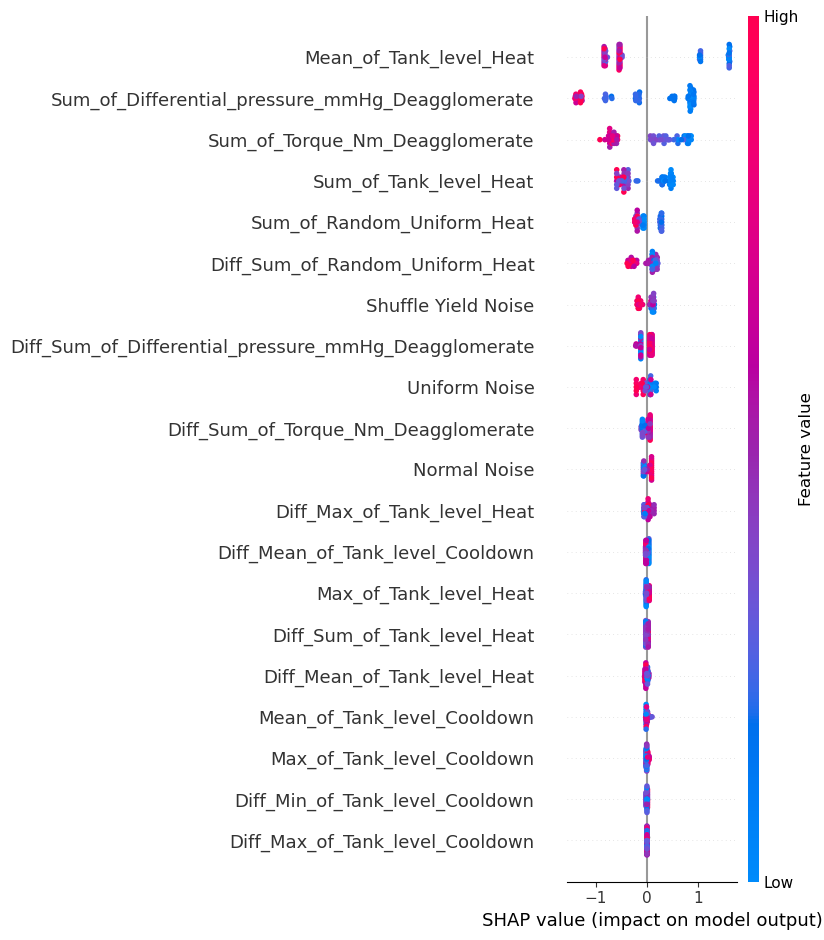

In [16]:
explainer_lgbm = shap.TreeExplainer(lgbm, feature_perturbation='tree_path_dependent') #by default if do not provide any backgound dataset: tree_path_dependent
shap_values_lgbm = explainer_lgbm.shap_values(X)

if is_plotting:
    shap.summary_plot(shap_values_lgbm, X)

In [17]:

df_shap_values = pd.DataFrame(shap_values_lgbm, index=X.index, columns=X.columns)

shap_lgbm_abs = abs(shap_values_lgbm)

mean_shap = shap_lgbm_abs.mean(axis=0)
std_shap = shap_lgbm_abs.std(axis=0)

#for some features,shap values always equal to 0 --> mean_shap contains null values
#for the ones that are null put an extremely small values?
mean_shap[np.where(mean_shap==0)] = 1e-9
CoefVariance_shap = std_shap/mean_shap 

#table of the mean and std shap
df_global_shap_values = pd.DataFrame({'Tags':X.columns,
                     'mean':mean_shap,
                     'std':std_shap,
                     'CoefVariance':CoefVariance_shap})

df_global_shap_values.sort_values(by='mean', ascending=False, inplace=True)

col_list_by_mean_shap = df_global_shap_values['Tags'].tolist()

# Reodering cloumns by shap mean value
X = X[col_list_by_mean_shap]
df_shap_values = df_shap_values[col_list_by_mean_shap]

list_ordered_factors = col_list_by_mean_shap
index_noise_shuffle = list_ordered_factors.index('Shuffle Yield Noise')
index_noise_normal = list_ordered_factors.index('Normal Noise')
index_noise_uni = list_ordered_factors.index('Uniform Noise')
min_index_noise = min(index_noise_shuffle,index_noise_normal,index_noise_uni)

col_name_noise = col_list_by_mean_shap[min_index_noise]
# Drop columns which SHAP average is below noise to ratio cut

# Gets the noise mean value
#noise_impact = float(df_global_shap_values['mean'].tail(1))
noise_impact = df_global_shap_values.set_index('Tags')['mean'][col_name_noise]
noise_cut_impact = signal_to_noise * noise_impact

# Finds columns with higher impact
bool_columns_after_noise_ratio_cut = df_global_shap_values['mean'].gt(noise_cut_impact)
col_list_after_noise_ratio_cut = df_global_shap_values[bool_columns_after_noise_ratio_cut]['Tags'].tolist()
print('list of columns above noise ratio: ', col_list_after_noise_ratio_cut)


# Appends noise column to visualize baseline
col_list_after_noise_ratio_cut.append(col_name_noise)

if 'SHAP_row_index' in col_list_after_noise_ratio_cut:
    # if a counter is important, this should be found by time index
    col_list_after_noise_ratio_cut.remove('SHAP_row_index')

# Alternative list with columns which SHAP average is just below noise (no noise ratio)
col_list_by_mean_shap_cut = col_list_by_mean_shap[0:(min_index_noise+1)]

# Simple index
# X['SHAP_row_index'] = range(1, len(X) + 1)

try:
    # Match JMP row index in case there were excluded rows
    X['SHAP_row_index'] = JMP_row_index
except:
    # Failed using JMP row indexes
    print('JMP row index was not passed properly to the solution.')
    X['SHAP_row_index'] = range(1, len(X) + 1)

X_SHAP_row_index = X['SHAP_row_index'].copy() # copy index before deleting
X.drop(['SHAP_row_index'], axis=1, inplace=True)


# TODO, which one is better?
# X = X[col_list_by_mean_shap_cut]
X = X[col_list_after_noise_ratio_cut]

#X_normalized = (X-X.min())/(X.max()-X.min()) # not robust to outliers
X_normalized = (X-X.quantile(0.03))/(X.quantile(0.97)-X.quantile(0.03))
X_normalized = X_normalized.clip(0, 1)

# add SHAP row index again
#X_normalized['SHAP_row_index'] = X_SHAP_row_index

if 'SHAP_row_index' in df_shap_values.columns:
    df_shap_values.drop(['SHAP_row_index'], axis=1, inplace=True)
# df_shap_values = df_shap_values[col_list_by_mean_shap_cut]
df_shap_values = df_shap_values[col_list_after_noise_ratio_cut]

# Full list until noise (no signal ratio used in case user wants to reduce it)
df_global_shap_values = df_global_shap_values.iloc[0:(min_index_noise+1),:]

toc = time.time() - tic
print('SHAP time [s]:', round(toc, 1))
tic = time.time()



list of columns above noise ratio:  ['Mean_of_Tank_level_Heat', 'Sum_of_Differential_pressure_mmHg_Deagglomerate', 'Sum_of_Torque_Nm_Deagglomerate', 'Sum_of_Tank_level_Heat', 'Sum_of_Random_Uniform_Heat', 'Diff_Sum_of_Random_Uniform_Heat']
SHAP time [s]: 0.9


In [18]:
# Tables for shap plots in JMP

if t_exists:
    df_shap_values = pd.concat([t, y, df_shap_values], axis=1)
    
    # Adds original row index as unique identifier
    # TODO use JMP index instead (in case there were excluded rows)
    df_shap_values.insert(0, X_SHAP_row_index.name, X_SHAP_row_index.values)
    
    df_shap_values_melted = df_shap_values.melt(id_vars=[X_SHAP_row_index.name, t.name, y.name])
    df_shap_values_melted.columns = [X_SHAP_row_index.name, t.name, y.name, 'tag', 'shap(value)'] 
    
    X_melted = X.melt()
    X_melted.columns = ['tag', 'value']
    
    X_norm_melted = X_normalized.melt()
    X_norm_melted.columns = ['tag', 'norm(value)']
    
    df_shap_plot_table = pd.concat([df_shap_values_melted,
                                    X_melted['value'],
                                    X_norm_melted['norm(value)']],
                                   axis=1)
    
else:
    df_shap_values = pd.concat([y, df_shap_values], axis=1)
    
    # Adds original row index as unique identifier
    df_shap_values.insert(0, X_SHAP_row_index.name, X_SHAP_row_index.values)
    
    df_shap_values_melted = df_shap_values.melt(id_vars=[X_SHAP_row_index.name, y.name])
    df_shap_values_melted.columns = [X_SHAP_row_index.name, y.name, 'tag', 'shap(value)'] 
                                    
    X_melted = X.melt()
    X_melted.columns = ['tag', 'value']
    
    X_norm_melted = X_normalized.melt()
    X_norm_melted.columns = ['tag', 'norm(value)']
    
    df_shap_plot_table = pd.concat([df_shap_values_melted,
                                    X_melted['value'],
                                    X_norm_melted['norm(value)']],
                                   axis=1)



In [19]:
# Exporting files to temp CSVs

In [20]:
df_shap_values_path_csv = os.path.join(temp_data_path,'df_shap_values.csv')
df_global_shap_values_path_csv = os.path.join(temp_data_path,'df_global_shap_values.csv')
df_shap_plot_table_path_csv = os.path.join(temp_data_path,'df_shap_plot_table.csv')

df_shap_values.to_csv(df_shap_values_path_csv)
df_global_shap_values.to_csv(df_global_shap_values_path_csv)
df_shap_plot_table.to_csv(df_shap_plot_table_path_csv)


toc = time.time() - tic
print('Exporting time [s]:', round(toc, 2))
tic = time.time()


Exporting time [s]: 0.06


In [21]:
# Visualization of tables in Notebook

In [22]:
df_shap_values

,SHAP_row_index,sum_umap_comp,Mean_of_Tank_level_Heat,Sum_of_Differential_pressure_mmHg_Deagglomerate,Sum_of_Torque_Nm_Deagglomerate,Sum_of_Tank_level_Heat,Sum_of_Random_Uniform_Heat,Diff_Sum_of_Random_Uniform_Heat,Shuffle Yield Noise
0,148,8.162816,-0.823591,-1.284386,0.070441,-0.510509,-0.206357,-0.373973,-0.128370
1,277,8.456388,-0.841230,-1.414392,-0.826779,0.329521,-0.079726,0.106274,0.106487
2,416,10.046206,-0.841230,-1.391996,-0.688936,0.299983,-0.079726,0.163409,0.106487
3,588,11.111189,-0.841230,-1.383114,-0.688936,-0.211061,-0.079726,0.163409,0.097605
4,769,11.929404,-0.529439,0.858211,-0.576769,-0.453384,-0.190885,-0.313485,0.133503
...,...,...,...,...,...,...,...,...,...
66,8797,10.936297,-0.817175,-0.688156,0.674774,-0.593478,-0.217679,-0.281181,0.080549
67,8938,13.468969,-0.547078,0.907157,0.236987,0.476098,-0.077306,0.143025,-0.194763
68,9043,15.102134,1.051057,0.535431,0.408880,0.476098,-0.064094,0.173163,-0.176570
69,9157,14.798052,1.614540,-0.225925,0.423211,0.463347,-0.056007,0.143025,0.117554


In [23]:
y.name

'sum_umap_comp'

In [24]:
# df_shap_values.describe()

In [25]:
df_global_shap_values

,Tags,mean,std,CoefVariance
5,Mean_of_Tank_level_Heat,0.909959,0.403377,0.443292
6,Sum_of_Differential_pressure_mmHg_Deagglomerate,0.835950,0.372458,0.445551
7,Sum_of_Torque_Nm_Deagglomerate,0.574237,0.241350,0.420296
4,Sum_of_Tank_level_Heat,0.436278,0.097966,0.224550
8,Sum_of_Random_Uniform_Heat,0.184897,0.084114,0.454923
17,Diff_Sum_of_Random_Uniform_Heat,0.177478,0.092232,0.519678
20,Shuffle Yield Noise,0.129103,0.032402,0.250976


In [26]:
#df_global_shap_values.describe()

In [27]:
df_shap_plot_table

,SHAP_row_index,sum_umap_comp,tag,shap(value),value,norm(value)
0,148,8.162816,Mean_of_Tank_level_Heat,-0.823591,55.516591,0.362110
1,277,8.456388,Mean_of_Tank_level_Heat,-0.841230,65.090810,0.523143
2,416,10.046206,Mean_of_Tank_level_Heat,-0.841230,74.690455,0.684603
3,588,11.111189,Mean_of_Tank_level_Heat,-0.841230,84.286524,0.846004
4,769,11.929404,Mean_of_Tank_level_Heat,-0.529439,84.237879,0.845186
...,...,...,...,...,...,...
492,8797,10.936297,Shuffle Yield Noise,0.080549,11.111189,0.366132
493,8938,13.468969,Shuffle Yield Noise,-0.194763,14.409424,0.776912
494,9043,15.102134,Shuffle Yield Noise,-0.176570,14.971634,0.846933
495,9157,14.798052,Shuffle Yield Noise,0.117554,12.899051,0.588802


In [28]:
#df_shap_plot_table.describe()

# UMAP Dimensionality reduction for selected inputs

In [29]:
# X has already the RF selected features ordered by importance
X.head()

,Mean_of_Tank_level_Heat,Sum_of_Differential_pressure_mmHg_Deagglomerate,Sum_of_Torque_Nm_Deagglomerate,Sum_of_Tank_level_Heat,Sum_of_Random_Uniform_Heat,Diff_Sum_of_Random_Uniform_Heat,Shuffle Yield Noise
0,55.516591,171.057,1935.154,2442.730,23.411530,NaN,15.708821
1,65.090810,138.593,2872.215,1366.907,10.167467,-13.244064,10.046206
2,74.690455,84.192,2565.176,1643.190,10.496692,0.329225,8.300966
3,84.286524,34.241,3412.354,1770.017,10.545072,0.048380,13.574102
4,84.237879,-165.300,3900.933,2779.850,18.573039,8.027968,12.135931


In [30]:
# Function was defined above

if not(is_unspervised_learning):
    n_umap_components = int(JMP_user_parameters['NdimUMAP'])
    distance = str(JMP_user_parameters['metric'][0])
    
    df_umap, n_umap_components = umap_princ_components(X, n_umap_components, distance)

In [31]:
# DO NOT EDIT THIS CELL

# This file is generated only if all the notebook was executed correctly
# JMP will stop if doesn't find it
python_execution_check_csv = os.path.join(temp_data_path,'python_execution.csv')

try:
    os.remove(python_execution_check_csv)
except:
    print('Generating file to confirm python execution')

pd.DataFrame({'Python': [1]}).to_csv(python_execution_check_csv)

#  END